<a href="https://colab.research.google.com/github/Rahulx911/grid-6.0/blob/main/FRESH0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [35]:
from google.colab import drive
import zipfile
import os

# Mount Google Drive
drive.mount('/content/drive')

# Path to the zip file in Google Drive
zip_file_path = '/content/drive/MyDrive/Fruits_Vegetables_Dataset_new.zip'

# Destination directory to extract the contents
output_directory = '/content/drive/MyDrive/dataset-fruveg-2'

def unzip_to_gdrive(zip_path, extract_path):
    """
    Unzips a file from Google Drive and extracts its contents to a specified directory.
    :param zip_path: Path to the zip file
    :param extract_path: Directory to save extracted contents
    """
    # Check if the zip file exists
    if not os.path.exists(zip_path):
        print(f"Zip file not found at: {zip_path}")
        return

    # Create the output directory if it doesn't exist
    if not os.path.exists(extract_path):
        os.makedirs(extract_path)

    # Unzip the file
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
        print(f"Extracted files to: {extract_path}")

# Unzip the file
unzip_to_gdrive(zip_file_path, output_directory)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Extracted files to: /content/drive/MyDrive/dataset-fruveg-2


In [36]:
import os

def verify_dataset_structure(dataset_dir):
    """
    Scans the dataset directory and prints the folder structure
    along with the total count of images in each subdirectory.
    """
    for root, dirs, files in os.walk(dataset_dir):
        if files:
            # Filter image files only (if needed)
            image_files = [file for file in files if file.lower().endswith(('png', 'jpg', 'jpeg'))]
            print(f"Directory: {root}")
            print(f"Number of images: {len(image_files)}")
            print("-" * 40)
        else:
            print(f"Directory: {root} is empty.")
            print("-" * 40)

# Set the dataset directory path
dataset_dir = '/content/drive/MyDrive/dataset-fruveg-2/Fruits_Vegetables_Dataset_new'

# Run the verification
verify_dataset_structure(dataset_dir)


Directory: /content/drive/MyDrive/dataset-fruveg-2/Fruits_Vegetables_Dataset_new
Number of images: 0
----------------------------------------
Directory: /content/drive/MyDrive/dataset-fruveg-2/Fruits_Vegetables_Dataset_new/frsshpineapple
Number of images: 83
----------------------------------------
Directory: /content/drive/MyDrive/dataset-fruveg-2/Fruits_Vegetables_Dataset_new/RottenCucumber
Number of images: 175
----------------------------------------
Directory: /content/drive/MyDrive/dataset-fruveg-2/Fruits_Vegetables_Dataset_new/rottenmango
Number of images: 83
----------------------------------------
Directory: /content/drive/MyDrive/dataset-fruveg-2/Fruits_Vegetables_Dataset_new/FreshTomato
Number of images: 644
----------------------------------------
Directory: /content/drive/MyDrive/dataset-fruveg-2/Fruits_Vegetables_Dataset_new/RottenBellpepper
Number of images: 142
----------------------------------------
Directory: /content/drive/MyDrive/dataset-fruveg-2/Fruits_Vegetables_

In [12]:
!pip install tensorflow --upgrade

  Using cached tensorflow-2.18.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.1 kB)
Using cached tensorflow-2.18.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (615.3 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.18.0 which is incompatible.


In [79]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetV2M
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import mixed_precision

# Disable mixed precision to avoid potential issues
mixed_precision.set_global_policy('float32')

# Limit GPU memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# Set seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Dataset path
dataset_dir = '/content/drive/MyDrive/dataset-fruveg-2/Fruits_Vegetables_Dataset_new'

# Image data generator
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # Use 20% of data for validation
)

# Model creation for Freshness Index Prediction
def create_freshness_index_model(input_shape=(224, 224, 3)):
    base_model = EfficientNetV2M(weights='imagenet', include_top=False, input_shape=input_shape)

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # Freshness index regression (1-10 scale)
    freshness_index_output = Dense(1, activation='linear', name='freshness_index_output')(x)

    # Create and compile the model
    model = Model(inputs=base_model.input, outputs=freshness_index_output)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss='mean_squared_error',
        metrics=['mean_absolute_error', 'accuracy']  # Added accuracy
    )

    return model

# Custom data generator for Freshness Index Prediction
def freshness_data_generator(generator):
    while True:
        images = next(generator)  # Retrieve image batch
        batch_size = images.shape[0]  # Use actual batch size from generator output
        freshness_labels = np.zeros((batch_size, 1))  # Freshness index (1-10 scale)

        # Retrieve filenames corresponding to the batch
        filenames = [generator.filenames[idx] for idx in generator.index_array[:batch_size]]
        for i, filename in enumerate(filenames):
            # Extract directory name
            dir_name = os.path.basename(os.path.dirname(filename)).lower()

            # Determine freshness index
            if 'fresh' in dir_name:
                freshness = np.random.uniform(7, 10)  # Fresh items closer to 10
            else:
                freshness = np.random.uniform(1, 4)  # Rotten items closer to 1

            freshness_labels[i] = freshness

        yield images, freshness_labels

# Training function
def train_freshness_index_model():
    # Initialize data generators
    train_generator = datagen.flow_from_directory(
        dataset_dir,
        target_size=(224, 224),  # EfficientNetV2M default input size
        batch_size=32,
        class_mode=None,
        subset='training',
        shuffle=True
    )

    validation_generator = datagen.flow_from_directory(
        dataset_dir,
        target_size=(224, 224),
        batch_size=32,
        class_mode=None,
        subset='validation',
        shuffle=True
    )

    model = create_freshness_index_model()

    # Debugging the generator
    generator = freshness_data_generator(train_generator)
    images, labels = next(generator)
    print(f"Debug: Images shape: {images.shape}")
    print(f"Debug: Freshness index labels shape: {labels.shape}")

    # Callbacks
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7, verbose=1)
    model_checkpoint = ModelCheckpoint('/content/drive/MyDrive/fiv1.keras', save_best_only=True, monitor='val_loss', verbose=1)

    # Train the model
    history = model.fit(
        freshness_data_generator(train_generator),
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        validation_data=freshness_data_generator(validation_generator),
        validation_steps=validation_generator.samples // validation_generator.batch_size,
        epochs=200,  # Train for 100 epochs
        callbacks=[reduce_lr, model_checkpoint]
    )

    model.save('/content/drive/MyDrive/fiv1.keras')
    print("Training completed!")

    # Calculate final validation accuracy
    val_results = model.evaluate(
        freshness_data_generator(validation_generator),
        steps=validation_generator.samples // validation_generator.batch_size
    )
# Run the training function
train_freshness_index_model()


Found 5899 images belonging to 23 classes.
Found 1461 images belonging to 23 classes.
Debug: Images shape: (32, 224, 224, 3)
Debug: Freshness index labels shape: (32, 1)
Epoch 1/200
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 727ms/step - accuracy: 0.0000e+00 - loss: 44.6082 - mean_absolute_error: 5.7343
Epoch 1: val_loss improved from inf to 29.28276, saving model to /content/drive/MyDrive/fiv1.keras
184/184 ━━━━━━━━━━━━━━━━━━━━ 341s 861ms/step - accuracy: 0.0000e+00 - loss: 44.5970 - mean_absolute_error: 5.7335 - val_accuracy: 0.0000e+00 - val_loss: 29.2828 - val_mean_absolute_error: 4.4569 - learning_rate: 1.0000e-04
Epoch 2/200
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - accuracy: 0.0000e+00 - loss: 32.0270 - mean_absolute_error: 4.6488
Epoch 2: val_loss did not improve from 29.28276
184/184 ━━━━━━━━━━━━━━━━━━━━ 64s 347ms/step - accuracy: 0.0000e+00 - loss: 32.0203 - mean_absolute_error: 4.6482 - val_accuracy: 0.0000e+00 - val_loss: 29.7522 - val_mean_absolute_error: 4.5521 - learning_rate: 1

In [78]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Load the trained model
model_path = '/content/drive/MyDrive/fiv1.keras'
model = load_model(model_path)

# Function to preprocess a single image
def preprocess_image(image_path, target_size=(224, 224)):
    image = load_img(image_path, target_size=target_size)  # Load and resize image
    image_array = img_to_array(image)  # Convert to array
    image_array = np.expand_dims(image_array, axis=0)  # Add batch dimension
    image_array = image_array / 255.0  # Normalize pixel values
    return image_array

# Function to predict freshness index and interpret results
def predict_freshness(image_path):
    image_array = preprocess_image(image_path)
    prediction = model.predict(image_array)  # Predict freshness index
    freshness_index = prediction[0][0]

    # Interpret freshness
    freshness_status = "Fresh" if 5.5 <= freshness_index <= 10 else "Not Fresh"

    # Estimate shelf life (scaling freshness index to days, for example)
    if freshness_status == "Fresh":
        shelf_life_days = int((freshness_index - 3) * 2)  # Example scaling: 4-10 -> 2-14 days
    else:
        shelf_life_days = 0  # Not Fresh items have no shelf life

    # Print results
    print(f"Freshness Index: {freshness_index:.2f}")
    print(f"Status: {freshness_status}")
    print(f"Estimated Shelf Life: {shelf_life_days} days")

# Test the model with a sample image
test_image_path = '/content/rottenapple 7.jpg'  # Replace with your test image path
predict_freshness(test_image_path)


1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
Image: rottenapple 7.jpg
Freshness Index: 4.76
Status: Not Fresh
Estimated Shelf Life: 0 days


In [37]:
import os
import numpy as np
from collections import Counter
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

# Set the seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Paths to the dataset
dataset_dir = '/content/drive/MyDrive/dataset-fruveg-2/Fruits_Vegetables_Dataset_new'

# Automatically infer the number of valid classes
class_dirs = [d for d in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, d))]
num_classes = len(class_dirs)

# Calculate class weights to handle imbalance
class_counts = {}
for class_name in class_dirs:
    class_path = os.path.join(dataset_dir, class_name)
    class_counts[class_name] = len(os.listdir(class_path))

# Generate class weights inversely proportional to the class counts
total_images = sum(class_counts.values())
class_weights = {
    idx: total_images / (num_classes * count)
    for idx, (class_name, count) in enumerate(sorted(class_counts.items()))
}
print("Class Weights:", class_weights)

# Data augmentation and preprocessing
datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    validation_split=0.2,  # Split dataset into training and validation
    rotation_range=20,     # Augmentations
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

def build_fruiznet(input_shape=(160, 160, 3), num_classes=num_classes):
    """Build the FruizNet CNN model."""
    model = Sequential()

    # First Convolutional Block
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Second Convolutional Block
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Third Convolutional Block
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Fourth Convolutional Block
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Flatten and Fully Connected Layers
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    # Output Layer
    model.add(Dense(num_classes, activation='softmax'))

    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

def train_fruiznet():
    """Train the FruizNet model on the fruit dataset."""
    # Prepare the data generators
    train_generator = datagen.flow_from_directory(
        dataset_dir,
        target_size=(160, 160),
        batch_size=16,
        class_mode='categorical',
        subset='training',
        shuffle=True
    )

    validation_generator = datagen.flow_from_directory(
        dataset_dir,
        target_size=(160, 160),
        batch_size=16,
        class_mode='categorical',
        subset='validation',
        shuffle=True
    )

    # Debugging: Print class indices
    print("Training generator class indices:", train_generator.class_indices)
    print("Validation generator class indices:", validation_generator.class_indices)

    # Build the FruizNet model
    model = build_fruiznet()

    # Callbacks for learning rate reduction and model checkpointing
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7, verbose=1)
    model_checkpoint = ModelCheckpoint(
        '/content/drive/MyDrive/fruiznet_best_model.keras',
        save_best_only=True,
        monitor='val_loss',
        verbose=1
    )

    # Train the model with class weights
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // validation_generator.batch_size,
        class_weight=class_weights,  # Include class weights
        epochs=100,  # Adjust epochs as needed
        callbacks=[reduce_lr, model_checkpoint]
    )

    # Save the final model
    model.save('/content/drive/MyDrive/fruiznet_final_model.keras')
    print("Training completed!")

# Run the training function
train_fruiznet()


Class Weights: {0: 1.0556350114416475, 1: 0.7244086760231623, 2: 0.517601683029453, 3: 0.4761321119855503, 4: 0.5330781453127257, 5: 0.4975396022918773, 6: 2.2441471571906355, 7: 1.4857085346215781, 8: 1.8233695652173914, 9: 1.5503045578659946, 10: 0.5495086360929125, 11: 3.8664222105814563, 12: 3.8664222105814563, 13: 1.6801730025039836, 14: 0.466443377148635, 15: 3.820393374741201, 16: 0.6946169772256728, 17: 0.780810324764625, 18: 3.8664222105814563, 19: 3.820393374741201, 20: 3.8664222105814563, 21: 0.7428542673107891, 22: 3.8664222105814563}
Found 5899 images belonging to 23 classes.
Found 1461 images belonging to 23 classes.
Training generator class indices: {'FreshApple': 0, 'FreshBellpepper': 1, 'FreshCarrot': 2, 'FreshCucumber': 3, 'FreshPotato': 4, 'FreshTomato': 5, 'RottenBellpepper': 6, 'RottenCarrot': 7, 'RottenCucumber': 8, 'RottenPotato': 9, 'RottenTomato': 10, 'freshbrocoli': 11, 'freshlemon': 12, 'freshmango': 13, 'freshoranges': 14, 'frsshpineapple': 15, 'rottenapple'

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 17/368 ━━━━━━━━━━━━━━━━━━━━ 53s 153ms/step - accuracy: 0.0976 - loss: 4.3188

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


367/368 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - accuracy: 0.2108 - loss: 2.8902
Epoch 1: val_loss improved from inf to 4.61271, saving model to /content/drive/MyDrive/fruiznet_best_model.keras
368/368 ━━━━━━━━━━━━━━━━━━━━ 93s 233ms/step - accuracy: 0.2113 - loss: 2.8874 - val_accuracy: 0.0570 - val_loss: 4.6127 - learning_rate: 1.0000e-04
Epoch 2/100
  1/368 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.5625 - loss: 2.4752

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_loss did not improve from 4.61271
368/368 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5625 - loss: 2.4752 - val_accuracy: 0.0000e+00 - val_loss: 4.7665 - learning_rate: 1.0000e-04
Epoch 3/100
367/368 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.4544 - loss: 1.6754
Epoch 3: val_loss improved from 4.61271 to 1.48249, saving model to /content/drive/MyDrive/fruiznet_best_model.keras
368/368 ━━━━━━━━━━━━━━━━━━━━ 82s 220ms/step - accuracy: 0.4545 - loss: 1.6751 - val_accuracy: 0.5440 - val_loss: 1.4825 - learning_rate: 1.0000e-04
Epoch 4/100
  1/368 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.6875 - loss: 1.3707
Epoch 4: val_loss improved from 1.48249 to 1.47993, saving model to /content/drive/MyDrive/fruiznet_best_model.keras
368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step - accuracy: 0.6875 - loss: 1.3707 - val_accuracy: 0.4000 - val_loss: 1.4799 - learning_rate: 1.0000e-04
Epoch 5/100
367/368 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.5306 - loss: 1.4648
Epoch 5:

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step
Predicted Class: FreshTomato
Class Probabilities: [4.1613616e-03 4.3719676e-03 3.1797537e-03 2.5435004e-04 4.6454412e-03
 5.1420569e-01 1.0752910e-03 1.3315235e-01 1.8952540e-04 2.9899548e-03
 3.0553782e-01 6.0879369e-04 6.4150355e-04 2.3354068e-04 2.3451031e-03
 4.4625782e-04 2.2704246e-04 1.5398052e-03 1.4741502e-02 6.6298083e-04
 3.9467537e-03 1.8619929e-04 6.5695442e-04]


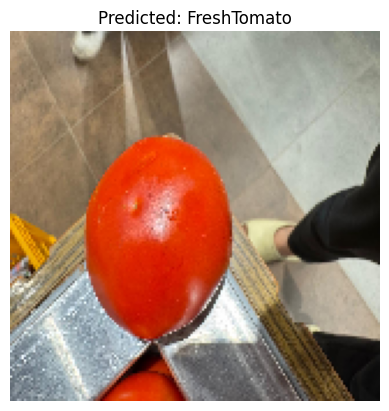

The image is classified as: FreshTomato


In [66]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import os
import matplotlib.pyplot as plt

# Paths
model_path = '/content/drive/MyDrive/fruiznet_final_model.keras'
dataset_dir = '/content/drive/MyDrive/dataset-fruveg-2/Fruits_Vegetables_Dataset_new'
sample_image_path = '/content/tomato_fresh_image.jpeg'  # Replace with your sample image path

# Load the trained model
model = load_model(model_path)

# Load class labels from the dataset directory
class_labels = sorted([d for d in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, d))])

def preprocess_image(image_path, target_size=(160, 160)):
    """Preprocess the image for prediction."""
    img = load_img(image_path, target_size=target_size)  # Load and resize the image
    img_array = img_to_array(img)  # Convert to numpy array
    img_array = img_array / 255.0  # Normalize pixel values
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img, img_array

def predict_image_class(image_path):
    """Predict the class of the input image."""
    # Preprocess the image
    original_img, img_array = preprocess_image(image_path)

    # Make predictions
    predictions = model.predict(img_array)
    predicted_class_idx = np.argmax(predictions[0])  # Get the index of the highest probability
    predicted_label = class_labels[predicted_class_idx]  # Map index to label

    # Print results
    print(f"Predicted Class: {predicted_label}")


    # Convert the original image (PIL) to a NumPy array for display
    original_img_array = np.array(original_img)

    # Display the image with the prediction
    plt.imshow(original_img_array.astype("uint8"))
    plt.title(f"Predicted: {predicted_label}")
    plt.axis('off')
    plt.show()

    return predicted_label

# Test the model with the sample image
predicted_label = predict_image_class(sample_image_path)


In [77]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import os
import matplotlib.pyplot as plt

# Paths
classification_model_path = '/content/drive/MyDrive/fruiznet_final_model.keras'
freshness_model_path = '/content/drive/MyDrive/fiv1.keras'
dataset_dir = '/content/drive/MyDrive/dataset-fruveg-2/Fruits_Vegetables_Dataset_new'
sample_image_path = '/content/tomato_fresh_image.jpeg'  # Replace with your sample image path

# Load the trained models
classification_model = load_model(classification_model_path)
freshness_model = load_model(freshness_model_path)

# Load class labels from the dataset directory
class_labels = sorted([d for d in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, d))])

def preprocess_image(image_path, target_size=(224, 224)):
    """Preprocess the image for prediction."""
    img = load_img(image_path, target_size=target_size)  # Resize the image to (224, 224)
    img_array = img_to_array(img)  # Convert to numpy array
    img_array = img_array / 255.0  # Normalize pixel values
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img, img_array

def predict_image_details(image_path):
    """Predict the class and freshness index of the input image."""
    # Preprocess the image
    original_img, img_array = preprocess_image(image_path, target_size=(224, 224))

    # Predict the class using classification model
    class_predictions = classification_model.predict(img_array)
    predicted_class_idx = np.argmax(class_predictions[0])  # Get the index of the highest probability
    predicted_label = class_labels[predicted_class_idx]  # Map index to label

    # Predict freshness index using the freshness model
    freshness_prediction = freshness_model.predict(img_array)
    freshness_index = freshness_prediction[0][0]

    # Determine freshness status
    freshness_status = "Fresh" if freshness_index >= 5 else "Not Fresh"

    # Print results
    print(f"Predicted Class: {predicted_label}")
    print(f"Class Probabilities: {class_predictions[0]}")
    print(f"Freshness Index: {freshness_index:.2f}")
    print(f"The produce is: {freshness_status}")

    # Display the image with predictions
    original_img_array = np.array(original_img)
    plt.imshow(original_img_array.astype("uint8"))
    plt.title(f"Type: {predicted_label}, Freshness: {freshness_status} ({freshness_index:.2f})")
    plt.axis('off')
    plt.show()

    return predicted_label, freshness_index

# Test the models with the sample image
predicted_label, freshness_index = predict_image_details(sample_image_path)
print(f"The image is classified as: {predicted_label}")
print(f"Freshness Index: {freshness_index:.2f}")


ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "dense_10" is incompatible with the layer: expected axis -1 of input shape to have value 25600, but received input with shape (1, 50176)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(1, 224, 224, 3), dtype=float32)
  • training=False
  • mask=None